# Creating the hotspot field from a volume of U.S. NWS data
>##  You can download raw radar data from:
      https://registry.opendata.aws/noaa-nexrad/
      -or-
      https://noaa-nexrad-level2.s3.amazonaws.com/index.html

      There are other archives if this one does not work for you

In [1]:
#include some useful things
from pathlib import Path
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from config import _EXAMPLEDATA_DIR

#Use the data supplied in the github repository
#
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KFDR20200522_220109_V06')
target_cappi_height = 5713  # m AMSL = -10°C isotherm height, !CASE SPECIFIC!

In [3]:
#
#read in the data, we use pyart, for this,
#but I think that this is the only part of pyart we use.
#We prefer xarray and xarray datasets for faster processing
#
radar_vol = pyart.io.read_nexrad_archive(filename)

In [4]:
#
#select the sweeps (elevations) in the data that we want
#to use in the computation of the hotspot field
#
from prepro.nexrad import prune_nexrad
#we want to use the survalence data and only a volumes worth
#we don't want the doppler cut data nor the extra sweeps from
#SAILS or Meso-Sails
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)

In [5]:
#run the radar data through a preproccessor that
#operates similarly to the United Statues NWS ORPG
#
from prepro.nexrad import preprocessor_norpg_xarray
metadata = {}
metadata['zdr_absolute_calibration'] = 0.0
metadata['z_absolute_calibration'] = 0.0
processed_vol = preprocessor_norpg_xarray(prune_vol, metadata)


In [6]:
# get the circular depolarization ratio and add it to the radar object
dr = pyart.retrieve.compute_cdr(processed_vol,
                                     rhohv_field='cross_correlation_ratio',
                                     zdr_field='differential_reflectivity')
processed_vol.add_field('dr', dr)



In [7]:
#add the dualpol processed fields to the pyart object
prepro_dr = pyart.retrieve.compute_cdr(processed_vol,
                                       rhohv_field='prepro_cc',
                                       zdr_field='prepro_zdr')

processed_vol.add_field('prepro_dr', prepro_dr)

In [8]:
#
#move the radials of data into an indexed_vv where the same azimuth(deg) is located at the same index(i)
#this can reduce the resolution of data collected at 0.5 azimuthal intervals to 1.0 degree azimuthal intervals.
#
from cappi.make_vv import get_indexed_vv
indexed_vv = get_indexed_vv(processed_vol)


2024-11-22 14:21:25,015 [MainThread  ] [INFO ]  1 of 14 current_elev: 0.48
2024-11-22 14:21:25,170 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:25,170 [MainThread  ] [INFO ]  2 of 14 current_elev: 0.88
2024-11-22 14:21:25,319 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:25,319 [MainThread  ] [INFO ]  3 of 14 current_elev: 1.32
2024-11-22 14:21:25,468 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:25,469 [MainThread  ] [INFO ]  4 of 14 current_elev: 1.80
2024-11-22 14:21:25,599 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:25,600 [MainThread  ] [INFO ]  5 of 14 current_elev: 2.42
2024-11-22 14:21:25,731 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:25,732 [MainThread  ] [INFO ]  6 of 14 current_elev: 3.12
2024-11-22 14:21:25,861 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, nu

In [9]:
# make azran CAPPI interpolation at the sepcified height from the indexed vitual volume
from cappi.azran import indexed_vv_to_cappi_amsl
#target_cappi_height = 5713  # m AMSL = -10°C isotherm height, !CASE SPECIFIC!
azran_ds = indexed_vv_to_cappi_amsl(indexed_vv, target_cappi_height)


2024-11-22 14:21:27,288 [MainThread  ] [INFO ]  reminder: using AMSL for target CAPPI height


In [10]:
from cappi.xy_cappi import azran_to_xy
#make xy interpolation and convert to xarray
#We choose to work on a grid that is 400x400 at 1km resolution
x_trg = np.arange(-200, 201)
y_trg = np.arange(-200, 201)
xycappi = azran_to_xy(azran_ds, x_trg, y_trg, grid_spacing_meters=1000.0, max_dist=2)


In [11]:
#Now we create the specific data needed for the hotspot algorithm
import hotspots.detection

#These are hotspots created from the raw radar data. (without expensive preprocessing)

# get hotspot field and detections for unprocessed fields
zdrcut = hotspots.detection.get_filtered_zdr(
        xycappi, refl_fieldname='reflectivity',
        zdr_fieldname='differential_reflectivity',
        cdr_fieldname='dr')

xycappi["zdr_cut"] = zdrcut

hotspot_field, hotspot_features = (
        hotspots.detection.apply_hotspot_method(
        xycappi, x_dim="x", y_dim="y", refl_fieldname='reflectivity',
        zdr_fieldname='zdr_cut'))



In [12]:
#these are the hotspots created from the processed radar data
#similar too the Untied States NWS ORPG 
#
# same for processed radar fields
zdrcut_proc = hotspots.detection.get_filtered_zdr(
        xycappi, refl_fieldname='prepro_zh', zdr_fieldname='prepro_zdr',
        cdr_fieldname='prepro_dr')

xycappi["zdr_cut_proc"] = zdrcut_proc

hotspot_field_proc, hotspot_features_proc = (
        hotspots.detection.apply_hotspot_method(
        xycappi, x_dim="x", y_dim="y", refl_fieldname='prepro_zh',
        zdr_fieldname='zdr_cut_proc'))


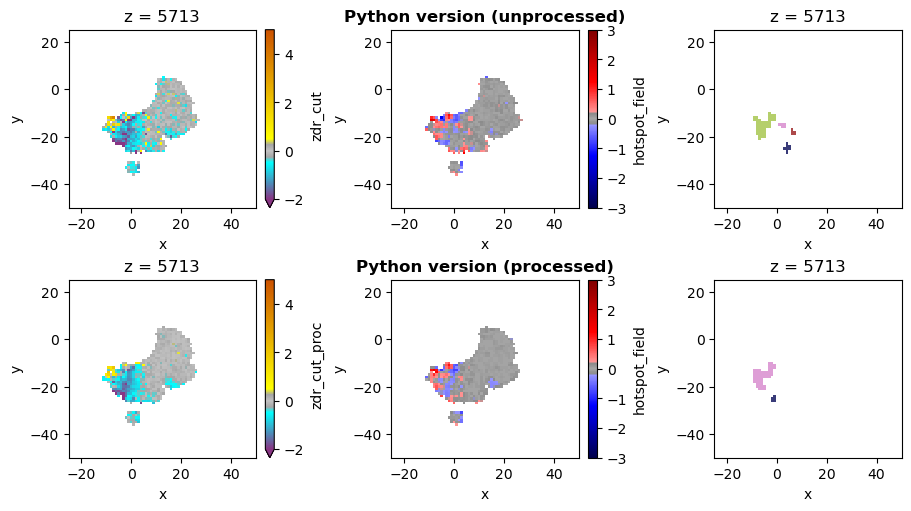

In [13]:
#Plot the results:
# now let's take a look at the output
import klaus_krause_cmap

xlim = (-25, 50)
ylim = (-50, 25)
hs_cmap = klaus_krause_cmap.get_hs_cmap(3)
zdr_cmap = klaus_krause_cmap.get_zdr_cmap(-2, 5)

fig, axs = plt.subplots(2, 3, figsize=(9, 5), constrained_layout=True)
# unprocessed fields
ax1 = axs[0, 0]
xycappi['zdr_cut'].plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=zdr_cmap, ax=ax1, vmin=-2,
    vmax=5)

ax2 = axs[0, 1]
hotspot_field.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=hs_cmap, vmin=-3,
                   vmax=3, ax=ax2)
ax2.set_title('Python version (unprocessed)', fontweight='bold')

ax3 = axs[0, 2]
hotspot_features.where(hotspot_features > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap='tab20b', add_colorbar=False,
    ax=ax3)
# new hotspots first
ax4 = axs[1, 0]
xycappi['zdr_cut_proc'].plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=zdr_cmap, ax=ax4, vmin=-2,
    vmax=5)

ax5 = axs[1, 1]
hotspot_field_proc.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=hs_cmap,
                        vmin=-3, vmax=3, ax=ax5)
ax5.set_title('Python version (processed)', fontweight='bold')

ax6 = axs[1, 2]
hotspot_features_proc.where(hotspot_features_proc > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap='tab20b', add_colorbar=False,
    ax=ax6)



